In [3]:
from scapy.all import rdpcap
import matplotlib.pyplot as plt
import numpy as np


ModuleNotFoundError: No module named 'matplotlib'

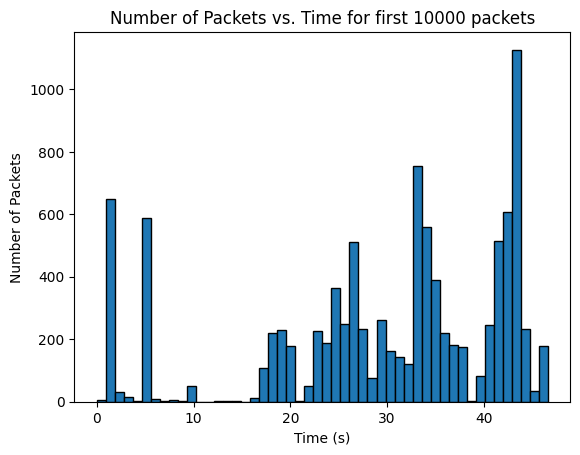

In [5]:
import matplotlib.pyplot as plt
from scapy.all import PcapReader

def plot_packets_vs_time(pcap_file, chunk_size):
    times = []
    packet_count = 0

    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            times.append(packet.time)
            packet_count += 1
            if packet_count >= chunk_size:
                break

    start_time = times[0]
    relative_times = [t - start_time for t in times]

    plt.hist(relative_times, bins=50, edgecolor='black')
    plt.xlabel('Time (s)')
    plt.ylabel('Number of Packets')
    plt.title(f'Number of Packets vs. Time for first {chunk_size} packets')
    plt.show()

pcap_file = "/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap" 
chunk_size = 10000 
plot_packets_vs_time(pcap_file, chunk_size)


In [1]:


def plot_packets_vs_time(pcap_file, chunk_size, bin_size=1):
    times = []
    packet_count = 0

    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No packets found in the specified chunk.")
        return

    start_time = times[0]
    relative_times = [t - start_time for t in times]

    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    plt.hist(relative_times, bins=bins, edgecolor='black')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of Packets')
    plt.title(f'Number of Packets vs. Time for first {chunk_size} packets')
    plt.grid(True)
    plt.show()

pcap_file = "/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap"
chunk_size = 10000

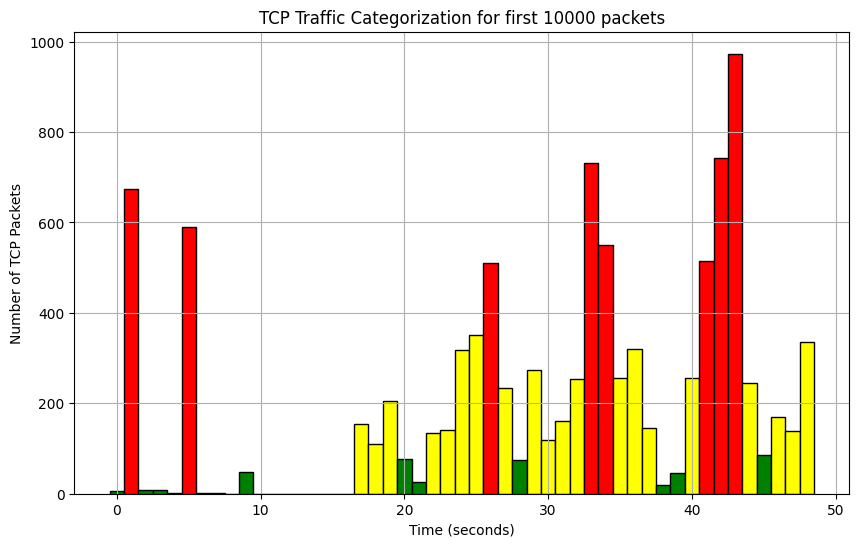

In [14]:


def categorize_traffic(packets_per_second, low_threshold, high_threshold):
    if packets_per_second < low_threshold:
        return 'Low'
    elif packets_per_second < high_threshold:
        return 'Medium'
    else:
        return 'High'

def plot_tcp_packets_vs_time(pcap_file, chunk_size, bin_size=1, low_threshold=10, high_threshold=50):
    times = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return

    start_time = times[0]
    relative_times = [t - start_time for t in times]

    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    counts, bin_edges = np.histogram(relative_times, bins=bins)
    packets_per_second = counts / bin_size

    categories = [categorize_traffic(p, low_threshold, high_threshold) for p in packets_per_second]

    plt.figure(figsize=(10, 6))
    for i, category in enumerate(categories):
        color = {'Low': 'green', 'Medium': 'yellow', 'High': 'red'}[category]
        plt.bar(bin_edges[i], counts[i], width=bin_size, color=color, edgecolor='black')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Number of TCP Packets')
    plt.title(f'TCP Traffic Categorization for first {chunk_size} packets')
    plt.grid(True)
    plt.show()

pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap'  
chunk_size = 10000  
bin_size = 1 
low_threshold = 100  
high_threshold = 400 
plot_tcp_packets_vs_time(pcap_file, chunk_size, bin_size, low_threshold, high_threshold)



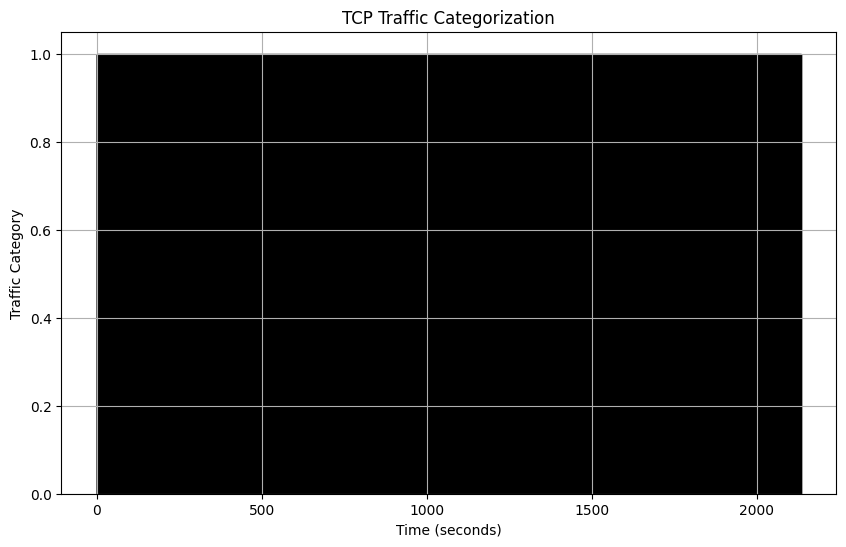

Accuracy of the Markov Chain model: 81.69%


In [25]:
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def categorize_traffic(packets_per_second, low_threshold, high_threshold):
    if packets_per_second < low_threshold:
        return 'Low'
    elif packets_per_second < high_threshold:
        return 'Medium'
    else:
        return 'High'

def read_and_categorize_traffic(pcap_file, chunk_size, bin_size, low_threshold, high_threshold):
    times = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return [], []
    start_time = times[0]
    relative_times = [t - start_time for t in times]

    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    counts, bin_edges = np.histogram(relative_times, bins=bins)
    packets_per_second = counts / bin_size

    categories = [categorize_traffic(p, low_threshold, high_threshold) for p in packets_per_second]

    return categories, bin_edges[:-1]  

def construct_transition_matrix(categories):
    transitions = defaultdict(int)
    for (current_state, next_state) in zip(categories[:-1], categories[1:]):
        transitions[(current_state, next_state)] += 1

    states = ['Low', 'Medium', 'High']
    transition_matrix = np.zeros((len(states), len(states)))

    for i, state_from in enumerate(states):
        total_transitions = sum(transitions[(state_from, state_to)] for state_to in states)
        if total_transitions > 0:
            for j, state_to in enumerate(states):
                transition_matrix[i, j] = transitions[(state_from, state_to)] / total_transitions

    return transition_matrix

def predict_next_state(current_state, transition_matrix):
    states = ['Low', 'Medium', 'High']
    state_index = states.index(current_state)
    next_state_index = np.argmax(transition_matrix[state_index])
    return states[next_state_index]

def validate_model(test_categories, transition_matrix):
    correct_predictions = 0
    for i in range(len(test_categories) - 1):
        if predict_next_state(test_categories[i], transition_matrix) == test_categories[i + 1]:
            correct_predictions += 1
    return correct_predictions / (len(test_categories) - 1)

def plot_traffic_categories(bin_edges, categories):
    plt.figure(figsize=(10, 6))
    for i, category in enumerate(categories):
        color = {'Low': 'green', 'Medium': 'yellow', 'High': 'red'}[category]
        plt.bar(bin_edges[i], 1, width=bin_size, color=color)

    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Category')
    plt.title('TCP Traffic Categorization')
    plt.grid(True)
    plt.show()

pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap' 
chunk_size = 1000000
bin_size = 1 
low_threshold = 100  
high_threshold = 400  

categories, bin_edges = read_and_categorize_traffic(pcap_file, chunk_size, bin_size, low_threshold, high_threshold)
plot_traffic_categories(bin_edges, categories)

train_categories, test_categories = train_test_split(categories, test_size=0.2, random_state=42, shuffle=False)

transition_matrix = construct_transition_matrix(train_categories)

accuracy = validate_model(test_categories, transition_matrix)
print(f'Accuracy of the Markov Chain model: {accuracy * 100:.2f}%')


/tmp/ipykernel_25744/416055126.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_categories))


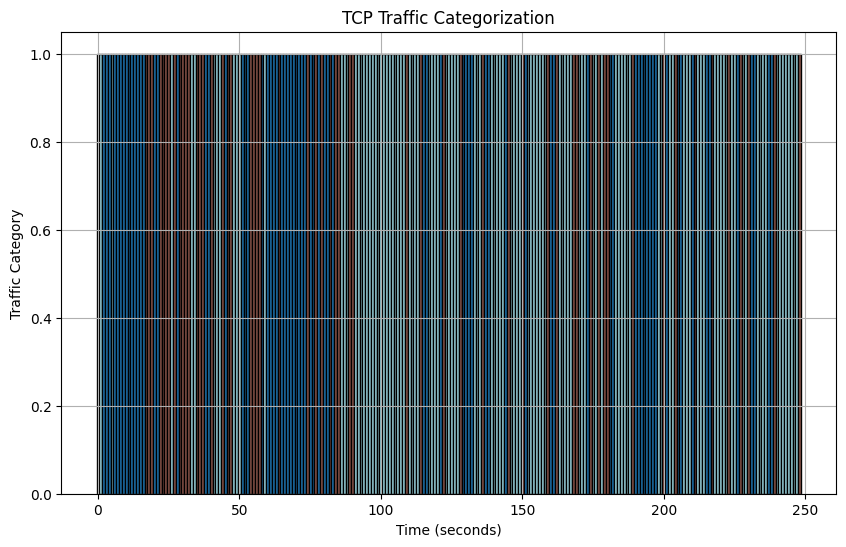

Accuracy of the Markov Chain model: 51.02%


In [24]:
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def categorize_traffic(packets_per_second, thresholds):
    for i, threshold in enumerate(thresholds):
        if packets_per_second < threshold:
            return f'State_{i}'
    return f'State_{len(thresholds)}'

def read_and_categorize_traffic(pcap_file, chunk_size, bin_size, thresholds):
    times = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return [], []

    start_time = times[0]
    relative_times = [t - start_time for t in times]

    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    counts, bin_edges = np.histogram(relative_times, bins=bins)
    packets_per_second = counts / bin_size

    categories = [categorize_traffic(p, thresholds) for p in packets_per_second]

    return categories, bin_edges[:-1]

def construct_transition_matrix(categories):
    transitions = defaultdict(int)
    for (current_state, next_state) in zip(categories[:-1], categories[1:]):
        transitions[(current_state, next_state)] += 1

    states = sorted(set(categories))
    transition_matrix = np.zeros((len(states), len(states)))

    for i, state_from in enumerate(states):
        total_transitions = sum(transitions[(state_from, state_to)] for state_to in states)
        if total_transitions > 0:
            for j, state_to in enumerate(states):
                transition_matrix[i, j] = transitions[(state_from, state_to)] / total_transitions

    return transition_matrix, states

def predict_next_state(current_state, transition_matrix, states):
    state_index = states.index(current_state)
    next_state_index = np.argmax(transition_matrix[state_index])
    return states[next_state_index]

def validate_model(test_categories, transition_matrix, states):
    correct_predictions = 0
    for i in range(len(test_categories) - 1):
        if predict_next_state(test_categories[i], transition_matrix, states) == test_categories[i + 1]:
            correct_predictions += 1
    return correct_predictions / (len(test_categories) - 1)

def plot_traffic_categories(bin_edges, categories):
    plt.figure(figsize=(10, 6))
    unique_categories = sorted(set(categories))
    colors = plt.cm.get_cmap('tab20', len(unique_categories))

    for i, category in enumerate(categories):
        color = colors(unique_categories.index(category))
        plt.bar(bin_edges[i], 1, width=bin_size, color=color, edgecolor='black')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Category')
    plt.title('TCP Traffic Categorization')
    plt.grid(True)
    plt.show()

pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap'  
chunk_size = 100000
bin_size = 1  
thresholds = [100, 400] 

categories, bin_edges = read_and_categorize_traffic(pcap_file, chunk_size, bin_size, thresholds)
plot_traffic_categories(bin_edges, categories)

train_categories, test_categories = train_test_split(categories, test_size=0.2, random_state=42, shuffle=False)

transition_matrix, states = construct_transition_matrix(train_categories)

accuracy = validate_model(test_categories, transition_matrix, states)
print(f'Accuracy of the Markov Chain model: {accuracy * 100:.2f}%')


/tmp/ipykernel_25744/3314935829.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_categories))


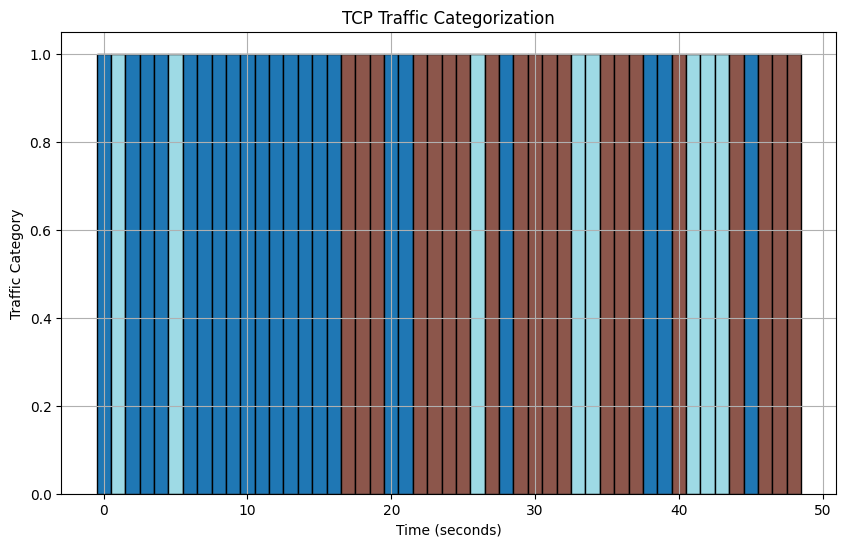

Accuracy of the Markov Chain model (predicting 5 steps ahead): 20.00%


In [22]:
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def categorize_traffic(packets_per_second, thresholds):
    for i, threshold in enumerate(thresholds):
        if packets_per_second < threshold:
            return f'State_{i}'
    return f'State_{len(thresholds)}'

def read_and_categorize_traffic(pcap_file, chunk_size, bin_size, thresholds):
    times = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return [], []

    start_time = times[0]
    relative_times = [t - start_time for t in times]

    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    counts, bin_edges = np.histogram(relative_times, bins=bins)
    packets_per_second = counts / bin_size

    categories = [categorize_traffic(p, thresholds) for p in packets_per_second]

    return categories, bin_edges[:-1]  # Return categories and corresponding bin edges (time intervals)

def construct_transition_matrix(categories):
    transitions = defaultdict(int)
    for (current_state, next_state) in zip(categories[:-1], categories[1:]):
        transitions[(current_state, next_state)] += 1

    states = sorted(set(categories))
    transition_matrix = np.zeros((len(states), len(states)))

    for i, state_from in enumerate(states):
        total_transitions = sum(transitions[(state_from, state_to)] for state_to in states)
        if total_transitions > 0:
            for j, state_to in enumerate(states):
                transition_matrix[i, j] = transitions[(state_from, state_to)] / total_transitions

    return transition_matrix, states

def multi_step_transition_matrix(transition_matrix, steps):
    return np.linalg.matrix_power(transition_matrix, steps)

def predict_next_state(current_state, transition_matrix, states, steps):
    state_index = states.index(current_state)
    multi_step_matrix = multi_step_transition_matrix(transition_matrix, steps)
    next_state_index = np.argmax(multi_step_matrix[state_index])
    return states[next_state_index]

def validate_model(test_categories, transition_matrix, states, steps):
    correct_predictions = 0
    for i in range(len(test_categories) - steps):
        if predict_next_state(test_categories[i], transition_matrix, states, steps) == test_categories[i + steps]:
            correct_predictions += 1
    return correct_predictions / (len(test_categories) - steps)

def plot_traffic_categories(bin_edges, categories):
    plt.figure(figsize=(10, 6))
    unique_categories = sorted(set(categories))
    colors = plt.cm.get_cmap('tab20', len(unique_categories))

    for i, category in enumerate(categories):
        color = colors(unique_categories.index(category))
        plt.bar(bin_edges[i], 1, width=bin_size, color=color, edgecolor='black')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Category')
    plt.title('TCP Traffic Categorization')
    plt.grid(True)
    plt.show()

# Example usage
pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap' 
chunk_size = 10000  
bin_size = 1  
thresholds = [100, 400]  
steps = 5

categories, bin_edges = read_and_categorize_traffic(pcap_file, chunk_size, bin_size, thresholds)
plot_traffic_categories(bin_edges, categories)

train_categories, test_categories = train_test_split(categories, test_size=0.2, random_state=42, shuffle=False)

transition_matrix, states = construct_transition_matrix(train_categories)

accuracy = validate_model(test_categories, transition_matrix, states, steps)
print(f'Accuracy of the Markov Chain model (predicting {steps} steps ahead): {accuracy * 100:.2f}%')


/tmp/ipykernel_25744/487276616.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_categories))


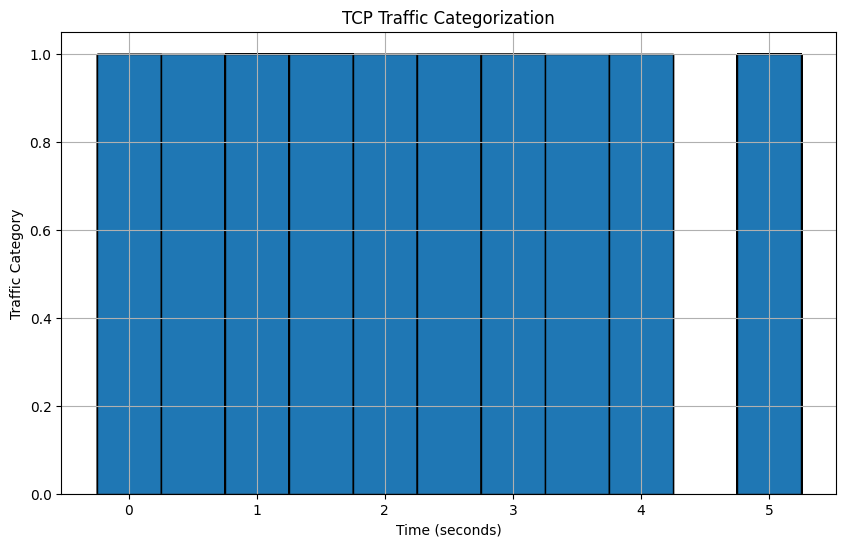

Accuracy of the Markov Chain model (predicting 1 steps ahead): 100.00%


In [27]:
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def categorize_traffic(packet, low_threshold, high_threshold):
    size = len(packet)
    if size < low_threshold:
        size_category = 'Small'
    elif size < high_threshold:
        size_category = 'Medium'
    else:
        size_category = 'Large'

    if TCP in packet:
        flags = packet[TCP].flags
        if flags & 0x02:  # SYN
            flag_category = 'SYN'
        elif flags & 0x10:  # ACK
            flag_category = 'ACK'
        elif flags & 0x01:  # FIN
            flag_category = 'FIN'
        else:
            flag_category = 'Other'
    else:
        flag_category = 'Non-TCP'

    return f'{size_category}_{flag_category}'

def read_and_categorize_traffic(pcap_file, chunk_size, bin_size, low_threshold, high_threshold):
    times = []
    categories = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                categories.append(categorize_traffic(packet, low_threshold, high_threshold))
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return [], []

    # Convert timestamps to relative times
    start_time = times[0]
    relative_times = [t - start_time for t in times]

    # Determine the range and bins for the histogram
    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    # Assign categories to time bins
    binned_categories = []
    current_bin_index = 0
    for t, category in zip(relative_times, categories):
        while current_bin_index < len(bins) - 1 and t >= bins[current_bin_index + 1]:
            current_bin_index += 1
        binned_categories.append((bins[current_bin_index], category))

    return binned_categories, bins[:-1]

def construct_transition_matrix(binned_categories):
    transitions = defaultdict(int)
    for (current_time, current_state), (next_time, next_state) in zip(binned_categories[:-1], binned_categories[1:]):
        transitions[(current_state, next_state)] += 1

    states = sorted(set(state for _, state in binned_categories))
    transition_matrix = np.zeros((len(states), len(states)))

    for i, state_from in enumerate(states):
        total_transitions = sum(transitions[(state_from, state_to)] for state_to in states)
        if total_transitions > 0:
            for j, state_to in enumerate(states):
                transition_matrix[i, j] = transitions[(state_from, state_to)] / total_transitions

    return transition_matrix, states

def multi_step_transition_matrix(transition_matrix, steps):
    return np.linalg.matrix_power(transition_matrix, steps)

def predict_next_state(current_state, transition_matrix, states, steps):
    state_index = states.index(current_state)
    multi_step_matrix = multi_step_transition_matrix(transition_matrix, steps)
    next_state_index = np.argmax(multi_step_matrix[state_index])
    return states[next_state_index]

def validate_model(test_binned_categories, transition_matrix, states, steps):
    correct_predictions = 0
    for i in range(len(test_binned_categories) - steps):
        if predict_next_state(test_binned_categories[i][1], transition_matrix, states, steps) == test_binned_categories[i + steps][1]:
            correct_predictions += 1
    return correct_predictions / (len(test_binned_categories) - steps)

def plot_traffic_categories(bin_edges, categories):
    plt.figure(figsize=(10, 6))
    unique_categories = sorted(set(category for _, category in categories))
    colors = plt.cm.get_cmap('tab20', len(unique_categories))

    for i, (bin_edge, category) in enumerate(categories):
        color = colors(unique_categories.index(category))
        plt.bar(bin_edge, 1, width=bin_size, color=color, edgecolor='black')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Category')
    plt.title('TCP Traffic Categorization')
    plt.grid(True)
    plt.show()

# Example usage
pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap'  
chunk_size = 1000 
bin_size = 0.5
low_threshold = 50  
high_threshold = 200  
steps = 1

binned_categories, bin_edges = read_and_categorize_traffic(pcap_file, chunk_size, bin_size, low_threshold, high_threshold)
plot_traffic_categories(bin_edges, binned_categories)

train_binned_categories, test_binned_categories = train_test_split(binned_categories, test_size=0.2, random_state=42, shuffle=False)

transition_matrix, states = construct_transition_matrix(train_binned_categories)

accuracy = validate_model(test_binned_categories, transition_matrix, states, steps)
print(f'Accuracy of the Markov Chain model (predicting {steps} steps ahead): {accuracy * 100:.2f}%')


/tmp/ipykernel_25744/3526437144.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_categories))


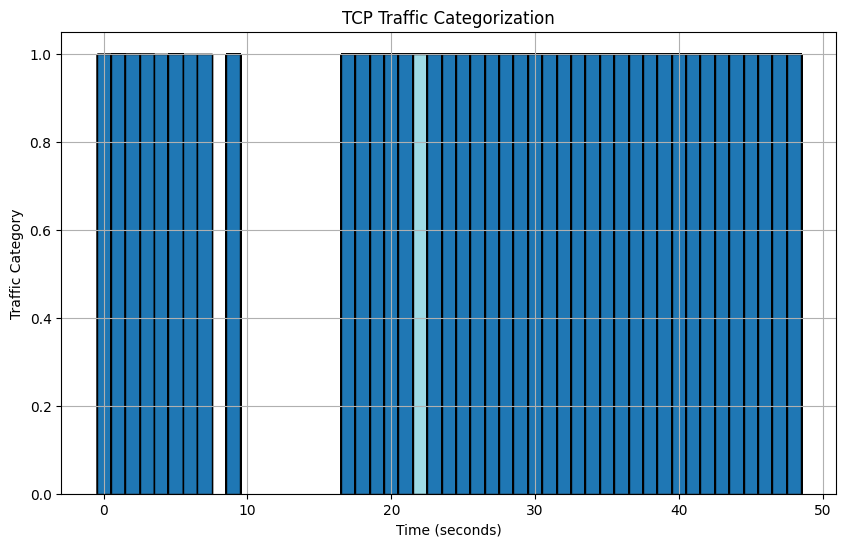

Accuracy of the Markov Chain model (predicting 1 steps ahead): 99.55%


In [29]:
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def categorize_traffic(packet, low_threshold, high_threshold):
    size = len(packet)
    if size < low_threshold:
        size_category = 'Small'
    elif size < high_threshold:
        size_category = 'Medium'
    else:
        size_category = 'Large'

    if TCP in packet:
        flags = packet[TCP].flags
        if flags & 0x02:  # SYN
            flag_category = 'SYN'
        elif flags & 0x10:  # ACK
            flag_category = 'ACK'
        elif flags & 0x01:  # FIN
            flag_category = 'FIN'
        else:
            flag_category = 'Other'
    else:
        flag_category = 'Non-TCP'

    return f'{size_category}_{flag_category}'

def read_and_categorize_traffic(pcap_file, chunk_size, bin_size, low_threshold, high_threshold):
    times = []
    categories = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                categories.append(categorize_traffic(packet, low_threshold, high_threshold))
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return [], []

    # Convert timestamps to relative times
    start_time = times[0]
    relative_times = [t - start_time for t in times]

    # Determine the range and bins for the histogram
    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    # Assign categories to time bins
    binned_categories = []
    current_bin_index = 0
    for t, category in zip(relative_times, categories):
        while current_bin_index < len(bins) - 1 and t >= bins[current_bin_index + 1]:
            current_bin_index += 1
        binned_categories.append((bins[current_bin_index], category))

    return binned_categories, bins[:-1]

def construct_transition_matrix(categories):
    transitions = defaultdict(int)
    for (current_state, next_state) in zip(categories[:-1], categories[1:]):
        transitions[(current_state, next_state)] += 1

    states = sorted(set(state for state in categories))
    transition_matrix = np.zeros((len(states), len(states)))

    for i, state_from in enumerate(states):
        total_transitions = sum(transitions[(state_from, state_to)] for state_to in states)
        if total_transitions > 0:
            for j, state_to in enumerate(states):
                transition_matrix[i, j] = transitions[(state_from, state_to)] / total_transitions

    return transition_matrix, states

def multi_step_transition_matrix(transition_matrix, steps):
    return np.linalg.matrix_power(transition_matrix, steps)

def predict_next_state(current_state, transition_matrix, states, steps):
    state_index = states.index(current_state)
    multi_step_matrix = multi_step_transition_matrix(transition_matrix, steps)
    next_state_index = np.argmax(multi_step_matrix[state_index])
    return states[next_state_index]

def validate_model(test_categories, transition_matrix, states, steps):
    correct_predictions = 0
    for i in range(len(test_categories) - steps):
        if predict_next_state(test_categories[i], transition_matrix, states, steps) == test_categories[i + steps]:
            correct_predictions += 1
    return correct_predictions / (len(test_categories) - steps)

def plot_traffic_categories(bin_edges, categories):
    plt.figure(figsize=(10, 6))
    unique_categories = sorted(set(category for _, category in categories))
    colors = plt.cm.get_cmap('tab20', len(unique_categories))

    for i, (bin_edge, category) in enumerate(categories):
        color = colors(unique_categories.index(category))
        plt.bar(bin_edge, 1, width=bin_size, color=color, edgecolor='black')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Category')
    plt.title('TCP Traffic Categorization')
    plt.grid(True)
    plt.show()

# Example usage
pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap'  # Replace with your pcap file
chunk_size = 10000  # Define the chunk size
bin_size = 1  # Define the bin size in seconds
low_threshold = 50  # Define the low traffic threshold (packet size)
high_threshold = 200  # Define the high traffic threshold (packet size)
steps = 1  # Number of steps (intervals) to predict ahead

binned_categories, bin_edges = read_and_categorize_traffic(pcap_file, chunk_size, bin_size, low_threshold, high_threshold)
plot_traffic_categories(bin_edges, binned_categories)

# Extract categories only for splitting
categories_only = [category for _, category in binned_categories]

# Split the data into training and testing sets
train_categories, test_categories = train_test_split(categories_only, test_size=0.2, random_state=42, shuffle=False)

# Construct the transition matrix from the training data
transition_matrix, states = construct_transition_matrix(train_categories)

# Validate the model using the test data
accuracy = validate_model(test_categories, transition_matrix, states, steps)
print(f'Accuracy of the Markov Chain model (predicting {steps} steps ahead): {accuracy * 100:.2f}%')


/tmp/ipykernel_25744/1894235999.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_categories))
/tmp/ipykernel_25744/1894235999.py:115: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_map(i), edgecolor='black') for i in range(len(unique_categories))]


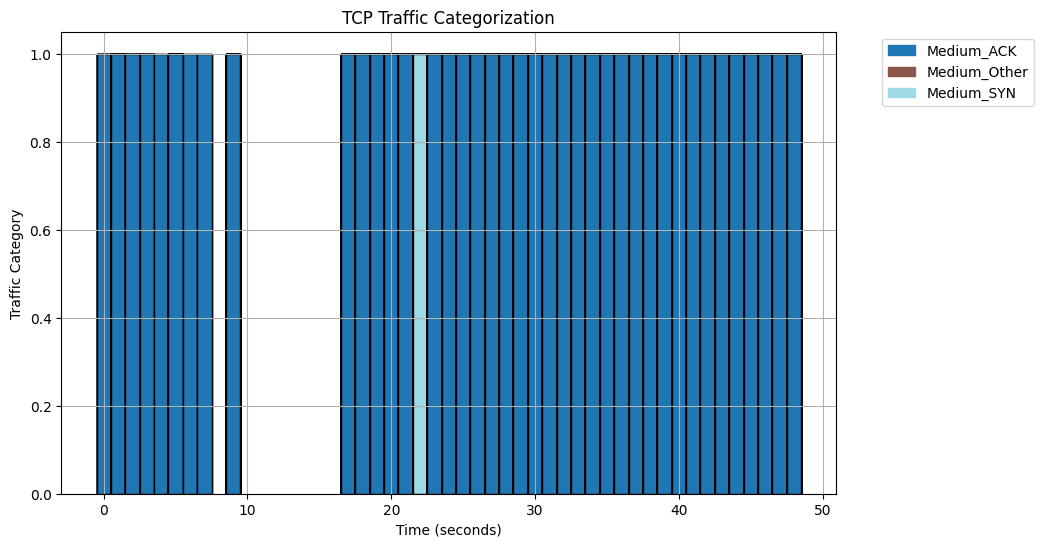

Accuracy of the Markov Chain model (predicting 5 steps ahead): 99.55%


In [30]:
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def categorize_traffic(packet, low_threshold, high_threshold):
    size = len(packet)
    if size < low_threshold:
        size_category = 'Small'
    elif size < high_threshold:
        size_category = 'Medium'
    else:
        size_category = 'Large'

    if TCP in packet:
        flags = packet[TCP].flags
        if flags & 0x02:  # SYN
            flag_category = 'SYN'
        elif flags & 0x10:  # ACK
            flag_category = 'ACK'
        elif flags & 0x01:  # FIN
            flag_category = 'FIN'
        else:
            flag_category = 'Other'
    else:
        flag_category = 'Non-TCP'

    return f'{size_category}_{flag_category}'

def read_and_categorize_traffic(pcap_file, chunk_size, bin_size, low_threshold, high_threshold):
    times = []
    categories = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                categories.append(categorize_traffic(packet, low_threshold, high_threshold))
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return [], []

    # Convert timestamps to relative times
    start_time = times[0]
    relative_times = [t - start_time for t in times]

    # Determine the range and bins for the histogram
    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    # Assign categories to time bins
    binned_categories = []
    current_bin_index = 0
    for t, category in zip(relative_times, categories):
        while current_bin_index < len(bins) - 1 and t >= bins[current_bin_index + 1]:
            current_bin_index += 1
        binned_categories.append((bins[current_bin_index], category))

    return binned_categories, bins[:-1]

def construct_transition_matrix(categories):
    transitions = defaultdict(int)
    for (current_state, next_state) in zip(categories[:-1], categories[1:]):
        transitions[(current_state, next_state)] += 1

    states = sorted(set(state for state in categories))
    transition_matrix = np.zeros((len(states), len(states)))

    for i, state_from in enumerate(states):
        total_transitions = sum(transitions[(state_from, state_to)] for state_to in states)
        if total_transitions > 0:
            for j, state_to in enumerate(states):
                transition_matrix[i, j] = transitions[(state_from, state_to)] / total_transitions

    return transition_matrix, states

def multi_step_transition_matrix(transition_matrix, steps):
    return np.linalg.matrix_power(transition_matrix, steps)

def predict_next_state(current_state, transition_matrix, states, steps):
    state_index = states.index(current_state)
    multi_step_matrix = multi_step_transition_matrix(transition_matrix, steps)
    next_state_index = np.argmax(multi_step_matrix[state_index])
    return states[next_state_index]

def validate_model(test_categories, transition_matrix, states, steps):
    correct_predictions = 0
    for i in range(len(test_categories) - steps):
        if predict_next_state(test_categories[i], transition_matrix, states, steps) == test_categories[i + steps]:
            correct_predictions += 1
    return correct_predictions / (len(test_categories) - steps)

def plot_traffic_categories(bin_edges, categories):
    plt.figure(figsize=(10, 6))
    unique_categories = sorted(set(category for _, category in categories))
    color_map = plt.cm.get_cmap('tab20', len(unique_categories))

    for i, (bin_edge, category) in enumerate(categories):
        color = color_map(unique_categories.index(category))
        plt.bar(bin_edge, 1, width=bin_size, color=color, edgecolor='black')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Category')
    plt.title('TCP Traffic Categorization')
    plt.grid(True)

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map(i), edgecolor='black') for i in range(len(unique_categories))]
    labels = unique_categories
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Example usage
pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap'  # Replace with your pcap file
chunk_size = 10000  # Define the chunk size
bin_size = 1  # Define the bin size in seconds
low_threshold = 50  # Define the low traffic threshold (packet size)
high_threshold = 200  # Define the high traffic threshold (packet size)
steps = 5  # Number of steps (intervals) to predict ahead

binned_categories, bin_edges = read_and_categorize_traffic(pcap_file, chunk_size, bin_size, low_threshold, high_threshold)
plot_traffic_categories(bin_edges, binned_categories)

categories_only = [category for _, category in binned_categories]

train_categories, test_categories = train_test_split(categories_only, test_size=0.2, random_state=42, shuffle=False)

transition_matrix, states = construct_transition_matrix(train_categories)

accuracy = validate_model(test_categories, transition_matrix, states, steps)
print(f'Accuracy of the Markov Chain model (predicting {steps} steps ahead): {accuracy * 100:.2f}%')


/tmp/ipykernel_25744/1662775217.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(unique_categories))
/tmp/ipykernel_25744/1662775217.py:115: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color_map(i), edgecolor='black') for i in range(len(unique_categories))]


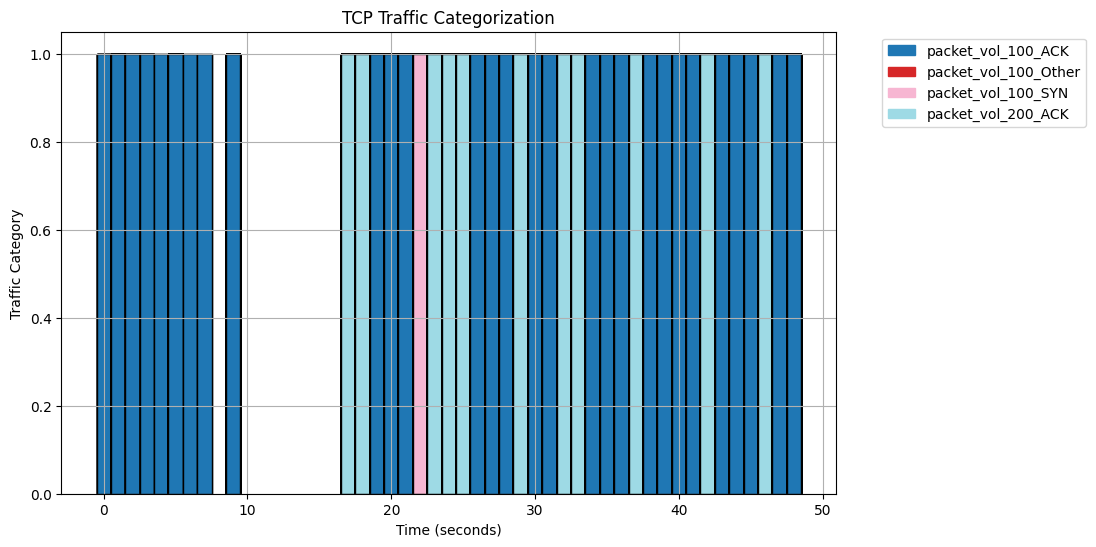

Accuracy of the Markov Chain model (predicting 1 steps ahead): 74.69%


In [36]:
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def categorize_traffic(packet, thresholds):
    size = len(packet)
    for i, threshold in enumerate(thresholds):
        if size < threshold:
            size_category = f'packet_vol_{threshold}'
            break
    else:
        size_category = f'Size_{len(thresholds)}'

    if TCP in packet:
        flags = packet[TCP].flags
        if flags & 0x02:  # SYN
            flag_category = 'SYN'
        elif flags & 0x10:  # ACK
            flag_category = 'ACK'
        elif flags & 0x01:  # FIN
            flag_category = 'FIN'
        else:
            flag_category = 'Other'
    else:
        flag_category = 'Non-TCP'

    return f'{size_category}_{flag_category}'

def read_and_categorize_traffic(pcap_file, chunk_size, bin_size, thresholds):
    times = []
    categories = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                categories.append(categorize_traffic(packet, thresholds))
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return [], []

    # Convert timestamps to relative times
    start_time = times[0]
    relative_times = [t - start_time for t in times]

    # Determine the range and bins for the histogram
    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    # Assign categories to time bins
    binned_categories = []
    current_bin_index = 0
    for t, category in zip(relative_times, categories):
        while current_bin_index < len(bins) - 1 and t >= bins[current_bin_index + 1]:
            current_bin_index += 1
        binned_categories.append((bins[current_bin_index], category))

    return binned_categories, bins[:-1]

def construct_transition_matrix(categories):
    transitions = defaultdict(int)
    for (current_state, next_state) in zip(categories[:-1], categories[1:]):
        transitions[(current_state, next_state)] += 1

    states = sorted(set(state for state in categories))
    transition_matrix = np.zeros((len(states), len(states)))

    for i, state_from in enumerate(states):
        total_transitions = sum(transitions[(state_from, state_to)] for state_to in states)
        if total_transitions > 0:
            for j, state_to in enumerate(states):
                transition_matrix[i, j] = transitions[(state_from, state_to)] / total_transitions

    return transition_matrix, states

def multi_step_transition_matrix(transition_matrix, steps):
    return np.linalg.matrix_power(transition_matrix, steps)

def predict_next_state(current_state, transition_matrix, states, steps):
    state_index = states.index(current_state)
    multi_step_matrix = multi_step_transition_matrix(transition_matrix, steps)
    next_state_index = np.argmax(multi_step_matrix[state_index])
    return states[next_state_index]

def validate_model(test_categories, transition_matrix, states, steps):
    correct_predictions = 0
    for i in range(len(test_categories) - steps):
        if predict_next_state(test_categories[i], transition_matrix, states, steps) == test_categories[i + steps]:
            correct_predictions += 1
    return correct_predictions / (len(test_categories) - steps)

def plot_traffic_categories(bin_edges, categories):
    plt.figure(figsize=(10, 6))
    unique_categories = sorted(set(category for _, category in categories))
    color_map = plt.cm.get_cmap('tab20', len(unique_categories))

    for i, (bin_edge, category) in enumerate(categories):
        color = color_map(unique_categories.index(category))
        plt.bar(bin_edge, 1, width=bin_size, color=color, edgecolor='black')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Category')
    plt.title('TCP Traffic Categorization')
    plt.grid(True)

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map(i), edgecolor='black') for i in range(len(unique_categories))]
    labels = unique_categories
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Example usage
pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap'  # Replace with your pcap file
chunk_size = 10000  # Define the chunk size
bin_size = 1  # Define the bin size in seconds
thresholds = [100, 200, 400]  # Define the thresholds for traffic categories
steps = 1  # Number of steps (intervals) to predict ahead

binned_categories, bin_edges = read_and_categorize_traffic(pcap_file, chunk_size, bin_size, thresholds)
plot_traffic_categories(bin_edges, binned_categories)

# Extract categories only for splitting
categories_only = [category for _, category in binned_categories]

# Split the data into training and testing sets
train_categories, test_categories = train_test_split(categories_only, test_size=0.2, random_state=42, shuffle=False)

# Construct the transition matrix from the training data
transition_matrix, states = construct_transition_matrix(train_categories)

# Validate the model using the test data
accuracy = validate_model(test_categories, transition_matrix, states, steps)
print(f'Accuracy of the Markov Chain model (predicting {steps} steps ahead): {accuracy * 100:.2f}%')


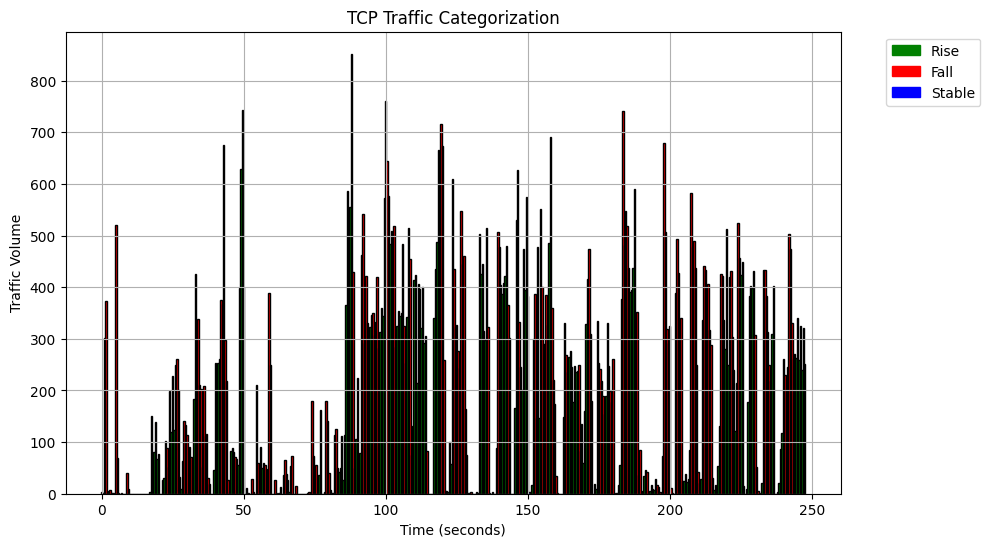

Accuracy of the Markov Chain model: 46.46%


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
from sklearn.model_selection import train_test_split
from collections import defaultdict

def calculate_traffic_volume(pcap_file, chunk_size, bin_size):
    times = []
    packet_count = 0

    # Read the PCAP file
    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        print("No TCP packets found in the specified chunk.")
        return [], []

    # Convert timestamps to relative times
    start_time = times[0]
    relative_times = [t - start_time for t in times]

    # Determine the range and bins for the histogram
    max_time = relative_times[-1]
    bins = np.arange(0, max_time + bin_size, bin_size)

    # Calculate packets per bin (traffic volume)
    counts, bin_edges = np.histogram(relative_times, bins=bins)
    return counts, bins[:-1]

def categorize_traffic_volumes(volumes):
    categories = []
    for i in range(1, len(volumes)):
        if volumes[i] > volumes[i - 1]:
            categories.append('Rise')
        elif volumes[i] < volumes[i - 1]:
            categories.append('Fall')
        else:
            categories.append('Stable')
    return categories

def construct_transition_matrix(categories):
    transitions = defaultdict(int)
    for (current_state, next_state) in zip(categories[:-1], categories[1:]):
        transitions[(current_state, next_state)] += 1

    states = ['Rise', 'Fall', 'Stable']
    transition_matrix = np.zeros((len(states), len(states)))

    for i, state_from in enumerate(states):
        total_transitions = sum(transitions[(state_from, state_to)] for state_to in states)
        if total_transitions > 0:
            for j, state_to in enumerate(states):
                transition_matrix[i, j] = transitions[(state_from, state_to)] / total_transitions

    return transition_matrix, states

def predict_next_state(current_state, transition_matrix, states):
    state_index = states.index(current_state)
    next_state_index = np.argmax(transition_matrix[state_index])
    return states[next_state_index]

def validate_model(test_categories, transition_matrix, states):
    correct_predictions = 0
    for i in range(len(test_categories) - 1):
        if predict_next_state(test_categories[i], transition_matrix, states) == test_categories[i + 1]:
            correct_predictions += 1
    return correct_predictions / (len(test_categories) - 1)

def plot_traffic_categories(bin_edges, volumes, categories):
    plt.figure(figsize=(10, 6))
    colors = {'Rise': 'green', 'Fall': 'red', 'Stable': 'blue'}

    for i in range(1, len(bin_edges)):
        plt.bar(bin_edges[i-1], volumes[i-1], width=bin_edges[i] - bin_edges[i-1], color=colors[categories[i-1]], edgecolor='black')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Volume')
    plt.title('TCP Traffic Categorization')
    plt.grid(True)

    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[key]) for key in colors]
    labels = list(colors.keys())
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Example usage
pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap'  # Replace with your pcap file
chunk_size = 100000  # Define the chunk size
bin_size = 0.5  # Define the bin size in seconds

volumes, bin_edges = calculate_traffic_volume(pcap_file, chunk_size, bin_size)
categories = categorize_traffic_volumes(volumes)
plot_traffic_categories(bin_edges, volumes, categories)

# Extract categories only for splitting
train_categories, test_categories = train_test_split(categories, test_size=0.2, random_state=42, shuffle=False)

# Construct the transition matrix from the training data
transition_matrix, states = construct_transition_matrix(train_categories)

# Validate the model using the test data
accuracy = validate_model(test_categories, transition_matrix, states)
print(f'Accuracy of the Markov Chain model: {accuracy * 100:.2f}%')


Epoch 1/20


/home/ydesai/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0598
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0535
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0479
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0427
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0382
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0343
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0312
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0292
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0283
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0286
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0298
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0309
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0313
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0308
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0299
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/st

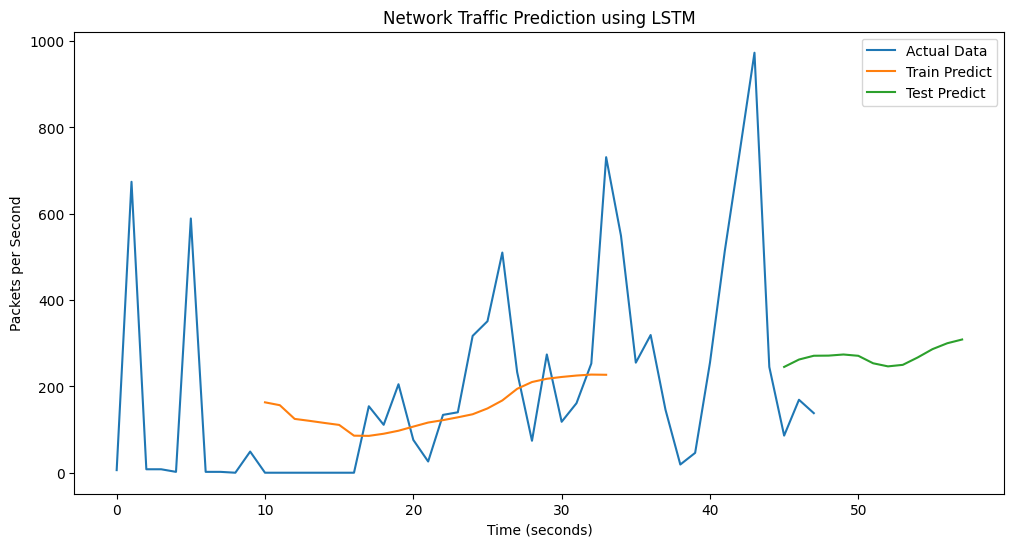

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scapy.all import PcapReader, TCP
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to read the PCAP file and extract packet timestamps
def read_pcap_file(pcap_file, chunk_size):
    times = []
    packet_count = 0

    with PcapReader(pcap_file) as pcap_reader:
        for packet in pcap_reader:
            if TCP in packet:
                times.append(packet.time)
                packet_count += 1
                if packet_count >= chunk_size:
                    break

    if not times:
        raise ValueError("No TCP packets found in the specified chunk.")
    
    return times

# Function to compute packets per second
def compute_packets_per_second(packet_times, bin_size=1):
    start_time = packet_times[0]
    end_time = packet_times[-1]
    bins = np.arange(start_time, end_time, bin_size)
    packet_counts, _ = np.histogram(packet_times, bins=bins)
    return packet_counts

# Function to create dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Main script to execute the steps
def main():
    pcap_file = '/home/ydesai/Downloads/capture2/ethcap_00001_20240418173623.pcap'  # Replace with your actual PCAP file path
    chunk_size = 10000  # Define the chunk size
    bin_size = 1  # Define the bin size in seconds
    time_step = 10  # Define the time step for LSTM

    # Read packet times from the PCAP file
    packet_times = read_pcap_file(pcap_file, chunk_size)

    # Compute packets per second
    packets_per_second = compute_packets_per_second(packet_times, bin_size)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    packets_per_second = packets_per_second.reshape(-1, 1)
    packets_per_second = scaler.fit_transform(packets_per_second)

    # Create dataset for LSTM
    X, Y = create_dataset(packets_per_second, time_step)

    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split the data into training and test sets
    train_size = int(len(X) * 0.67)
    test_size = len(X) - train_size
    train_X, test_X = X[0:train_size], X[train_size:len(X)]
    train_Y, test_Y = Y[0:train_size], Y[train_size:len(Y)]

    # Create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(train_X, train_Y, epochs=20, batch_size=32, verbose=1)

    # Make predictions
    train_predict = model.predict(train_X)
    test_predict = model.predict(test_X)

    # Invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    train_Y = scaler.inverse_transform([train_Y])
    test_predict = scaler.inverse_transform(test_predict)
    test_Y = scaler.inverse_transform([test_Y])

    # Calculate accuracy metrics
    train_mae = mean_absolute_error(train_Y[0], train_predict[:, 0])
    train_mse = mean_squared_error(train_Y[0], train_predict[:, 0])
    test_mae = mean_absolute_error(test_Y[0], test_predict[:, 0])
    test_mse = mean_squared_error(test_Y[0], test_predict[:, 0])

    print(f'Train MAE: {train_mae:.4f}')
    print(f'Train MSE: {train_mse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')
    print(f'Test MSE: {test_mse:.4f}')

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(packets_per_second), label='Actual Data')
    plt.plot(np.arange(time_step, time_step+len(train_predict)), train_predict, label='Train Predict')
    plt.plot(np.arange(len(train_predict)+(2*time_step)+1, len(train_predict)+(2*time_step)+1+len(test_predict)), test_predict, label='Test Predict')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Packets per Second')
    plt.title('Network Traffic Prediction using LSTM')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
